# Projet 7 : Implémentez un modèle de scoring
*Philippe LONJON (janvier 2020)*

---
Ce projet consiste à développer un modèle de scoring, qui donnera une prédiction sur la probabilité de faillite d'un client qui demande un prêt.
Il s'agit d'un problème :
* **Supervisé** : Les étiquettes (Défauts de crédit) sont connus
* **Classification** : Les valeurs à prédire sont des variables qualitatives
---
## Notebook 1 : Nettoyage des données et création des variables
Le notebook comprend :
- le nettoyage des données
- la création de nouvelles variables (features engineering)
- l'aggrégation des données par client


Les données utilisées proviennent la société Home Credit Group, dans le cadre d'une compétition Kaggle.<br>
Elles peuvent être téléchargées à l'adresse suivante : [https://kaggle.com/c/home-credit-default-risk/data](https://kaggle.com/c/home-credit-default-risk/data)<br><br>
Nous utiliserons les tables relatives à l'entrainement du modèle, soit :
- application_train
- bureau
- bureau balance
- credit_card_balance
- installments_payments
- POS_CASH_balance
- previous_balance

Elles sont à placer dans le répertoire : `data/raw`

#### Chargement des packages
Afin de ne pas surcharger les notebooks, les fonctions créées, sont regroupées dans un module ``fonctions08``.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
pd.set_option('max_columns', 50)
pd.set_option('max_rows', 30)

# Module des fonctions du notebook
import fonctions08 as f

# Modules preprocessing
from sklearn.preprocessing import LabelEncoder

# Divers
from time import time, strftime, gmtime
import gc

# Heure démarrage
t0=time()

# Autoreload pour prise en compte des changments dans le module fonctions
%load_ext autoreload
%autoreload 1
%aimport fonctions08

Les fichiers de données sont assez importants, nous allons surveiller la RAM utilisée.

In [2]:
# Mémoire démarrage
print(f"Mémoire utilisée : {f.memory_usage():.0f} Mb")

svmem(total=34322874368, available=29829271552, percent=13.1, used=4493602816, free=29829271552)
Mémoire utilisée : 139 Mb


De même, nous surveillerons les variables créées, et supprimerons celles devenues inutiles.

In [3]:
# Fonction pour lister les variables créées
def var_active(var_init=[]):
    """
    Input : list of variables to remove from the result
    Return : list of variables created by the script
    """
    var_list = [ var for var in globals() if var not in var_init and not var.startswith('_')]
    return var_list

# Liste des variables intiales à ne pas prendre en compte
var_init = dir()
var_init.append(['var_init', 'var_active'])

# 1. Application
Nous commençons avec la table principale, qui regroupe les informations concernant la demande de crédit en cours.<br>
Le chargement des fichiers .csv se fait avec une fonction optimisant la RAM utilisée.

In [4]:
# Chargement dataframe
application = f.import_csv("data/raw/application_train.csv", nrows=None)

Memory usage of dataframe is 286.23 MB
Memory usage after optimization is: 59.54 MB
Decreased by 79.2%


On regarde ensuite les dimensions du dataframe, avec identification de la clé primaire.

In [5]:
# description du dataframe
f.df_info(application, keep=True)
f.check_key(application, ['SK_ID_CURR'])

Shape : 307511 entries and 122 columns
No duplicate values : True
SK_ID_CURR is a primary key : True


Il y a 122 variables, nous regardons à quel type elles correspondent.

In [6]:
# Listes des variables qualitatives et quantitatives
cols_categorical = application.select_dtypes(include='category')\
    .columns.tolist()

cols_numeric = application.select_dtypes(exclude='category').columns.tolist()

print(f"Les données comprennent {len(cols_categorical)} variables qualitatives"
      f" et {len(cols_numeric)} variables quantitatives")

# Distribution de l'étiquette
print("\nDistribution de la variable cible :")
application['TARGET'].value_counts()

Les données comprennent 16 variables qualitatives et 106 variables quantitatives

Distribution de la variable cible :


0    282686
1     24825
Name: TARGET, dtype: int64

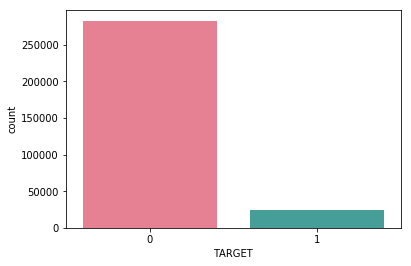

In [7]:
# Distribution de TARGET
sns.countplot(x='TARGET', data=application, palette='husl')

Cette table contient les étiquettes à prédire, 0 ou 1.<br>
La distribution de cette variable n'est pas équilibrée, avec une majorité de 0.
### 1.1 Nettoyage de la table
Nous passons au nettoyage de la table.<br>
Les outliers ou valeurs non renseignées sont remplacées par la valeur ``np.nan``.<br>
Nous gardons le valeurs manquantes car nous utiliserons un modèle qui les prend en charge.

In [8]:
# Variable avec outliers
application[['DAYS_EMPLOYED']].describe()

,DAYS_EMPLOYED
count,307511.000000
mean,63815.045904
std,141275.766519
min,-17912.000000
25%,-2760.000000
50%,-1213.000000
75%,-289.000000
max,365243.000000


La variable DAYS_EMPLOYED (nombre de jours employé) comporte un outlier avec la valeur 365243, on peut passer au nettoyage :

In [9]:
# Copie dataframe pour nettoyage des données
df_cleaned = application.copy()

# XNA correspond aux valeurs catégorielles non renseignées dans les tables HOME CREDIT
df_cleaned.replace('XNA', np.nan, inplace=True)

# Outliers et valeurs assimilables à des valeurs absentes 
df_cleaned['DAYS_EMPLOYED'].replace(365243, np.nan, inplace=True)
df_cleaned['NAME_FAMILY_STATUS'].replace('Unknown', np.nan, inplace=True)
df_cleaned['DAYS_LAST_PHONE_CHANGE'].replace(0, np.nan, inplace=True)

### 1.2 Création de nouvelles variables
Nous créons diverses variables, relatives au crédit demandé ou aux scores donnés par des établissements externes.

In [10]:
# Création variable de la durée du prêt
df_cleaned['AMT_DURATION'] = \
    df_cleaned['AMT_CREDIT'] / df_cleaned['AMT_ANNUITY']

# Ratio annuite / revenu
df_cleaned['ANNUITY_INCOME_RATIO'] = \
    df_cleaned['AMT_ANNUITY'] / df_cleaned['AMT_INCOME_TOTAL']

# Ratio credit demandé / revenu
df_cleaned['CREDIT_INCOME_RATIO'] = df_cleaned['AMT_CREDIT'] / df_cleaned['AMT_INCOME_TOTAL']

# Ratio bien à acheter / crédit demandé
df_cleaned['GOODS_CREDIT_RATIO'] = \
    df_cleaned['AMT_GOODS_PRICE'] / df_cleaned['AMT_CREDIT'] 

# Ratio durée emploi / age
df_cleaned['EMPLOYED_BIRTH_RATIO'] = \
    df_cleaned['DAYS_EMPLOYED'] / df_cleaned['DAYS_BIRTH']

# Moyenne des scores externes
df_cleaned['EXT_SOURCE_ALL'] = df_cleaned\
    .loc[:, ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']]\
    .mean(axis=1)

Nous ajoutons un préfixe (nom de la table) aux variables, afin d'identifier la table d'origine des variables.

In [11]:
# Ajout préfixe application aux noms de colonnes
df_cleaned.columns = ['application_' + col if col not in ['SK_ID_CURR', 'TARGET']
                      else col for col in df_cleaned.columns]

### 1.3 Sauvegarde des données
Les variables de la table sont sauvegardées, la jointure avec les autres tables se fera sur le notebook suivant.

In [12]:
# Features application
df_cleaned.head()

,SK_ID_CURR,TARGET,application_NAME_CONTRACT_TYPE,application_CODE_GENDER,application_FLAG_OWN_CAR,application_FLAG_OWN_REALTY,application_CNT_CHILDREN,application_AMT_INCOME_TOTAL,application_AMT_CREDIT,application_AMT_ANNUITY,application_AMT_GOODS_PRICE,application_NAME_TYPE_SUITE,application_NAME_INCOME_TYPE,application_NAME_EDUCATION_TYPE,application_NAME_FAMILY_STATUS,application_NAME_HOUSING_TYPE,application_REGION_POPULATION_RELATIVE,application_DAYS_BIRTH,application_DAYS_EMPLOYED,application_DAYS_REGISTRATION,application_DAYS_ID_PUBLISH,application_OWN_CAR_AGE,application_FLAG_MOBIL,application_FLAG_EMP_PHONE,application_FLAG_WORK_PHONE,...,application_FLAG_DOCUMENT_9,application_FLAG_DOCUMENT_10,application_FLAG_DOCUMENT_11,application_FLAG_DOCUMENT_12,application_FLAG_DOCUMENT_13,application_FLAG_DOCUMENT_14,application_FLAG_DOCUMENT_15,application_FLAG_DOCUMENT_16,application_FLAG_DOCUMENT_17,application_FLAG_DOCUMENT_18,application_FLAG_DOCUMENT_19,application_FLAG_DOCUMENT_20,application_FLAG_DOCUMENT_21,application_AMT_REQ_CREDIT_BUREAU_HOUR,application_AMT_REQ_CREDIT_BUREAU_DAY,application_AMT_REQ_CREDIT_BUREAU_WEEK,application_AMT_REQ_CREDIT_BUREAU_MON,application_AMT_REQ_CREDIT_BUREAU_QRT,application_AMT_REQ_CREDIT_BUREAU_YEAR,application_AMT_DURATION,application_ANNUITY_INCOME_RATIO,application_CREDIT_INCOME_RATIO,application_GOODS_CREDIT_RATIO,application_EMPLOYED_BIRTH_RATIO,application_EXT_SOURCE_ALL
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018799,-9461,-637.0,-3648.0,-2120,NaN,1,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,16.461104,0.121978,2.007889,0.863262,0.067329,0.161784
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003542,-16765,-1188.0,-1186.0,-291,NaN,1,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,36.234085,0.132217,4.790750,0.873211,0.070862,0.466675
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010033,-19046,-225.0,-4260.0,-2531,26.0,1,1,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,20.000000,0.100000,2.000000,1.000000,0.011814,0.642822
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,297000.0,Unaccompanied,Working,Secondary / secondary special,Civil marriage,House / apartment,0.008018,-19005,-3039.0,-9832.0,-2437,NaN,1,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,10.532818,0.219900,2.316167,0.949845,0.159905,0.650391
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,513000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.028656,-19932,-3038.0,-4312.0,-3458,NaN,1,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,23.461618,0.179963,4.222222,1.000000,0.152418,0.322754


In [13]:
# Features client et emprunt pour modelisation
df_cleaned.to_csv("data/features/features_application.csv", index=False)

### 1.4 Creation dataframe des données clients pour la dashboard
En paralèlle des données pour la modélisation, nous créons un dataframe des données que nous afficherons dans le dashboard.<br>
Il s'agit essentiellement des données descriptives, relatives aux clients et aux emprunts demandés.

In [14]:
# Données client et emprunt pour dashboard
dash_data = pd.DataFrame(index=df_cleaned.SK_ID_CURR)
dash_data.index.name = 'client'
dash_data = dash_data.reset_index()

# Données client
dash_data['age'] = df_cleaned['application_DAYS_BIRTH']\
    .apply(lambda x: int(-x / 365))
dash_data['income_type'] = df_cleaned['application_NAME_INCOME_TYPE']
dash_data['income'] = np.round(df_cleaned['application_AMT_INCOME_TOTAL'], 0)
dash_data['car_owner'] = df_cleaned['application_FLAG_OWN_CAR']
dash_data['home_owner'] = df_cleaned['application_FLAG_OWN_REALTY']

# Données emprunt 
dash_data['credit_type'] = df_cleaned['application_NAME_CONTRACT_TYPE']
dash_data['credit'] = np.round(df_cleaned['application_AMT_CREDIT'], 0)
dash_data['annuity'] = np.round(df_cleaned['application_AMT_ANNUITY'], 0)
dash_data['duration'] = np.round(df_cleaned['application_AMT_DURATION'], 0)

dash_data.head()

,client,age,income_type,income,car_owner,home_owner,credit_type,credit,annuity,duration
0,100002,25,Working,202500.0,N,Y,Cash loans,406598.0,24700.0,16.0
1,100003,45,State servant,270000.0,N,N,Cash loans,1293502.0,35698.0,36.0
2,100004,52,Working,67500.0,Y,Y,Revolving loans,135000.0,6750.0,20.0
3,100006,52,Working,135000.0,N,Y,Cash loans,312682.0,29686.0,11.0
4,100007,54,Working,121500.0,N,Y,Cash loans,513000.0,21866.0,23.0


### 1.5 Gestion de la RAM
Nous listons les variables créées, et supprimons celles que nous n'utiliserons plus.

In [15]:
# Variables à supprimer pour libérer de la mémoire
var_active(var_init=var_init)

['var_init',
 'application',
 'cols_categorical',
 'cols_numeric',
 'df_cleaned',
 'dash_data']

In [16]:
# Mémoire avant suppression
print(f"Mémoire utilisée : {f.memory_usage():.0f} Mb")

# Suppression des variables pour libérer de la mémoire
gc.enable()
del application, cols_categorical, cols_numeric
del df_cleaned
gc.collect()

# Mémoire après suppression
print(f"Mémoire utilisée : {f.memory_usage():.0f} Mb")

svmem(total=34322874368, available=29371678720, percent=14.4, used=4951195648, free=29371678720)
Mémoire utilisée : 557 Mb
svmem(total=34322874368, available=29680484352, percent=13.5, used=4642390016, free=29680484352)
Mémoire utilisée : 261 Mb


# 2. bureau
La deuxième Table concerne les emprunts contractés auprès d'autres institutions financières.

In [17]:
# Chargement fichier
bureau = f.import_csv("data/raw/bureau.csv")

Memory usage of dataframe is 222.62 MB
Memory usage after optimization is: 78.57 MB
Decreased by 64.7%


Nous affichons les dimensions de la table, et identifions la clé primaire.

In [18]:
# description du dataframe
f.df_info(bureau)
f.check_key(bureau, ['SK_ID_BUREAU'])

Shape : 1716428 entries and 17 columns
No duplicate values : True


,column type,unique,null values (nb),null values (%),first line
column name,,,,,
SK_ID_CURR,int32,NaN,0,0,215354
SK_ID_BUREAU,int32,NaN,0,0,5714462
CREDIT_ACTIVE,category,4,0,0,Closed
CREDIT_CURRENCY,category,4,0,0,currency 1
DAYS_CREDIT,int16,NaN,0,0,-497
CREDIT_DAY_OVERDUE,int16,NaN,0,0,0
DAYS_CREDIT_ENDDATE,float16,NaN,105553,6.14957,-153
DAYS_ENDDATE_FACT,float16,NaN,633653,36.917,-153
AMT_CREDIT_MAX_OVERDUE,float32,NaN,1124488,65.5133,NaN


SK_ID_BUREAU is a primary key : True


``SK_ID_BUREAU`` identifie un emprunt, il faudra aggréger les données par client.<br>
La table comprend 17 variables, on regarde à quel type elles correspondent.

In [19]:
# Listes des variables qualitatives et quantitatives
cols_categorical = bureau.select_dtypes(include='category')\
    .columns.tolist()

cols_numeric = bureau.select_dtypes(exclude='category').columns.tolist()

print(f"Les données comprennent {len(cols_categorical)} variables qualitatives"
      f" et {len(cols_numeric)} variables quantitatives")

Les données comprennent 3 variables qualitatives et 14 variables quantitatives


### 2.1 Nettoyage de la table
Nous passons au nettoyage de la table.<br>
Nous identifions d'abord les outlliers.

In [20]:
# Variables avec outliers
bureau[['DAYS_CREDIT_ENDDATE', 'DAYS_ENDDATE_FACT', 'DAYS_CREDIT_UPDATE']].describe()

,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,DAYS_CREDIT_UPDATE
count,1610875.0,1082775.0,1.716428e+06
mean,NaN,NaN,-5.937483e+02
std,NaN,NaN,7.207473e+02
min,-42048.0,-42016.0,-4.194700e+04
25%,-1138.0,-1489.0,-9.080000e+02
50%,-330.0,-897.0,-3.950000e+02
75%,474.0,-425.0,-3.300000e+01
max,31200.0,0.0,3.720000e+02


Ces valeurs expriment des jours, et dépassent les 40000 (plus de 100 ans), indépendemment du signe.
Ces outliers, et les valeurs non renseignées sont remplacées par la valeur ``np.nan``.<br>

In [21]:
# Copie dataframe pour nettoyage des données
df_cleaned = bureau.copy()

# XNA correspond aux valeurs catégorielles non renseignées dans les tables HOME CREDIT
df_cleaned.replace('XNA', np.nan, inplace=True)

#Traitement des outliers
df_cleaned['DAYS_CREDIT_ENDDATE'].values[df_cleaned['DAYS_CREDIT_ENDDATE'] < -40000] = np.nan
df_cleaned['DAYS_ENDDATE_FACT'].values[df_cleaned['DAYS_ENDDATE_FACT'] < -40000] = np.nan

df_cleaned = df_cleaned.astype({'DAYS_CREDIT_UPDATE': 'float32'})
df_cleaned['DAYS_CREDIT_UPDATE'].values[df_cleaned['DAYS_CREDIT_UPDATE'] < -40000] = np.nan

### 2.2 Variable encoding
La variable qualitative ``CREDIT_ACTIVE`` prend des valeurs pouvant être ordonnées selon la qualité du crédit :<br>
variant d'un bon crédit (Closed) à un mauvais crédit (Bad debt).<br>
On peut alors effectuer un label encoding sur cette variable.

In [22]:
# Variable catégorielle avec ordre
bureau.CREDIT_ACTIVE.unique()

[Closed, Active, Sold, Bad debt]
Categories (4, object): [Closed, Active, Sold, Bad debt]

In [23]:
# Labelencoding de CREDIT_ACTIVE selon ordre défini
le = LabelEncoder()
le.classes_ = pd.Series(['Closed', 'Active', 'Sold', 'Bad debt']).to_numpy()
df_cleaned['CREDIT_ACTIVE'] = le.transform(df_cleaned.CREDIT_ACTIVE)

### 2.3 Création de variables
Nous allons compter le nombre d'emprunts extérieurs par client.

In [24]:
# Nombre d'emprunts précédents
previous_loan_counts = df_cleaned.groupby(['SK_ID_CURR'], as_index=False)['SK_ID_BUREAU']\
    .count()\
    .rename(columns={'SK_ID_BUREAU': 'bureau_PREVIOUS_EXTERN_LOANS'})\
    .fillna(0)\
    .set_index('SK_ID_CURR')
previous_loan_counts.head()

,bureau_PREVIOUS_EXTERN_LOANS
SK_ID_CURR,
100001,7
100002,8
100003,4
100004,2
100005,3


### 2.4 Aggrégation des données de la table par client
La table comprend des données d'emprunts, nous allons aggréger les données par client (un client pouvant avoir plusieurs emprunts).<br>
L'aggrégation se fait en 3 étapes :
- Aggrégation des variables numériques par client
- Aggrégation des variables qualitatives par client
- Jointure des deux tables créées

In [25]:
# Aggregation des données numériques
bureau_agg_num = f.agg_numerical(df_cleaned.drop(columns= ['SK_ID_BUREAU']),
                                 parent_var='SK_ID_CURR',
                                 df_name='bureau')
print(bureau_agg_num.shape)
bureau_agg_num.head()

(305811, 61)


,bureau_DAYS_CREDIT_sum,bureau_DAYS_ENDDATE_FACT_sum,bureau_DAYS_CREDIT_min,bureau_DAYS_CREDIT_ENDDATE_min,bureau_DAYS_ENDDATE_FACT_min,bureau_DAYS_ENDDATE_FACT_mean,bureau_DAYS_CREDIT_mean,bureau_DAYS_CREDIT_UPDATE_sum,bureau_DAYS_ENDDATE_FACT_max,bureau_DAYS_CREDIT_UPDATE_min,bureau_DAYS_CREDIT_UPDATE_mean,bureau_DAYS_CREDIT_max,bureau_DAYS_CREDIT_UPDATE_max,bureau_CNT_CREDIT_PROLONG_min,bureau_CREDIT_DAY_OVERDUE_min,bureau_AMT_CREDIT_SUM_OVERDUE_min,bureau_CREDIT_DAY_OVERDUE_mean,bureau_CREDIT_DAY_OVERDUE_max,bureau_CREDIT_DAY_OVERDUE_sum,bureau_AMT_CREDIT_SUM_OVERDUE_mean,bureau_AMT_CREDIT_SUM_OVERDUE_max,bureau_AMT_CREDIT_SUM_OVERDUE_sum,bureau_CNT_CREDIT_PROLONG_mean,bureau_CNT_CREDIT_PROLONG_max,bureau_CNT_CREDIT_PROLONG_sum,...,bureau_CREDIT_ACTIVE_sum,bureau_DAYS_ENDDATE_FACT_count,bureau_AMT_CREDIT_SUM_LIMIT_count,bureau_AMT_CREDIT_SUM_DEBT_count,bureau_DAYS_CREDIT_ENDDATE_count,bureau_AMT_ANNUITY_count,bureau_DAYS_CREDIT_UPDATE_count,bureau_AMT_CREDIT_SUM_count,bureau_CREDIT_ACTIVE_count,bureau_DAYS_CREDIT_ENDDATE_mean,bureau_DAYS_CREDIT_ENDDATE_sum,bureau_DAYS_CREDIT_ENDDATE_max,bureau_AMT_ANNUITY_mean,bureau_AMT_ANNUITY_max,bureau_AMT_ANNUITY_sum,bureau_AMT_CREDIT_SUM_DEBT_mean,bureau_AMT_CREDIT_SUM_min,bureau_AMT_CREDIT_SUM_mean,bureau_AMT_CREDIT_SUM_DEBT_max,bureau_AMT_CREDIT_SUM_max,bureau_AMT_CREDIT_SUM_DEBT_sum,bureau_AMT_CREDIT_SUM_sum,bureau_AMT_CREDIT_MAX_OVERDUE_min,bureau_AMT_CREDIT_MAX_OVERDUE_mean,bureau_AMT_CREDIT_MAX_OVERDUE_max
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
100001,-5145,-3302.0,-1572,-1329.0,-1328.0,-825.500000,-735.000000,-652.0,-544.0,-155.0,-93.142860,-49,-6.0,0,0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0,0,...,3,4,6,7,7,7,7,7,7,82.428571,577.0,1778.0,3545.357143,10822.5,24817.5,85240.928571,85500.0,207623.571429,373239.0,378000.000000,596686.5,1.453365e+06,NaN,NaN,NaN
100002,-6992,-4185.0,-1437,-1072.0,-1185.0,-697.500000,-874.000000,-3999.0,-36.0,-1185.0,-499.875000,-103,-7.0,0,0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0,0,...,2,6,4,5,6,7,8,8,8,-349.000000,-2094.0,780.0,0.000000,0.0,0.0,49156.200000,0.0,108131.945557,245781.0,450000.000000,245781.0,8.650556e+05,0.0,1681.029004,5043.64502
100003,-5603,-3293.0,-2586,-2434.0,-2132.0,-1097.666667,-1400.750000,-3264.0,-540.0,-2131.0,-816.000000,-606,-43.0,0,0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0,0,...,1,3,4,4,4,0,4,4,4,-544.500000,-2178.0,1216.0,NaN,NaN,0.0,0.000000,22248.0,254350.125000,0.0,810000.000000,0.0,1.017400e+06,0.0,0.000000,0.00000
100004,-1734,-1065.0,-1326,-595.0,-683.0,-532.500000,-867.000000,-1064.0,-382.0,-682.0,-532.000000,-408,-382.0,0,0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0,0,...,0,2,2,2,2,0,2,2,2,-488.500000,-977.0,-382.0,NaN,NaN,0.0,0.000000,94500.0,94518.898438,0.0,94537.796875,0.0,1.890378e+05,0.0,0.000000,0.00000
100005,-572,-123.0,-373,-128.0,-123.0,-123.000000,-190.666667,-163.0,-123.0,-121.0,-54.333332,-62,-11.0,0,0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0,0,...,2,1,3,3,3,3,3,3,3,439.333333,1318.0,1324.0,1420.500000,4261.5,4261.5,189469.500000,29826.0,219042.000000,543087.0,568800.000000,568408.5,6.571260e+05,0.0,0.000000,0.00000


In [26]:
# Aggrégation des donnes qualitatives
bureau_agg_cat = f.agg_categorical(df_cleaned,
                                   parent_var='SK_ID_CURR',
                                   df_name='bureau')
print(bureau_agg_cat.shape)
bureau_agg_cat.head()

(305811, 39)


,bureau_CREDIT_TYPE_Mobile operator loan_mean,bureau_CREDIT_TYPE_Mobile operator loan_sum,bureau_CREDIT_TYPE_Loan for purchase of shares (margin lending)_mean,bureau_CREDIT_TYPE_Loan for purchase of shares (margin lending)_sum,bureau_CREDIT_TYPE_Interbank credit_mean,bureau_CREDIT_TYPE_Interbank credit_sum,bureau_CREDIT_TYPE_Real estate loan_mean,bureau_CREDIT_TYPE_Real estate loan_sum,bureau_CREDIT_CURRENCY_currency 4_mean,bureau_CREDIT_CURRENCY_currency 4_sum,bureau_CREDIT_CURRENCY_currency 3_mean,bureau_CREDIT_CURRENCY_currency 3_sum,bureau_CREDIT_TYPE_Loan for the purchase of equipment_mean,bureau_CREDIT_TYPE_Loan for the purchase of equipment_sum,bureau_CREDIT_TYPE_Cash loan (non-earmarked)_mean,bureau_CREDIT_TYPE_Cash loan (non-earmarked)_sum,bureau_CREDIT_TYPE_Unknown type of loan_mean,bureau_CREDIT_TYPE_Unknown type of loan_sum,bureau_CREDIT_TYPE_Another type of loan_mean,bureau_CREDIT_TYPE_Another type of loan_sum,bureau_CREDIT_TYPE_Loan for working capital replenishment_mean,bureau_CREDIT_TYPE_Loan for working capital replenishment_sum,bureau_CREDIT_CURRENCY_currency 2_mean,bureau_CREDIT_CURRENCY_currency 2_sum,bureau_CREDIT_TYPE_Mortgage_mean,bureau_CREDIT_TYPE_Mortgage_sum,bureau_CREDIT_TYPE_Microloan_mean,bureau_CREDIT_TYPE_Microloan_sum,bureau_CREDIT_TYPE_Car loan_mean,bureau_CREDIT_TYPE_Car loan_sum,bureau_CREDIT_TYPE_Loan for business development_mean,bureau_CREDIT_TYPE_Loan for business development_sum,bureau_CREDIT_TYPE_Credit card_mean,bureau_CREDIT_TYPE_Credit card_sum,bureau_CREDIT_TYPE_Consumer credit_mean,bureau_CREDIT_CURRENCY_currency 1_mean,bureau_CREDIT_TYPE_Consumer credit_sum,bureau_CREDIT_CURRENCY_currency 1_sum,bureau_CREDIT_CURRENCY_currency 1_count
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
100001,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.000000,0,1.000000,1.0,7,7,7
100002,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.500000,4,0.500000,1.0,4,8,8
100003,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.500000,2,0.500000,1.0,2,4,4
100004,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.000000,0,1.000000,1.0,2,2,2
100005,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.333333,1,0.666667,1.0,2,3,3


On effectue la jointure des deux tables créées, auxquelles on ajoute la variable de décompte des emprunts par client.

In [27]:
# Dataframe des données du bureau pour jointure avec application
bureau_agg = previous_loan_counts\
    .merge(bureau_agg_num, on='SK_ID_CURR', how='outer')\
    .merge(bureau_agg_cat, on='SK_ID_CURR', how='outer')\

# Infos dataframe pour jointure
print(bureau_agg.shape)
bureau_agg.head()

(305811, 101)


,bureau_PREVIOUS_EXTERN_LOANS,bureau_DAYS_CREDIT_sum,bureau_DAYS_ENDDATE_FACT_sum,bureau_DAYS_CREDIT_min,bureau_DAYS_CREDIT_ENDDATE_min,bureau_DAYS_ENDDATE_FACT_min,bureau_DAYS_ENDDATE_FACT_mean,bureau_DAYS_CREDIT_mean,bureau_DAYS_CREDIT_UPDATE_sum,bureau_DAYS_ENDDATE_FACT_max,bureau_DAYS_CREDIT_UPDATE_min,bureau_DAYS_CREDIT_UPDATE_mean,bureau_DAYS_CREDIT_max,bureau_DAYS_CREDIT_UPDATE_max,bureau_CNT_CREDIT_PROLONG_min,bureau_CREDIT_DAY_OVERDUE_min,bureau_AMT_CREDIT_SUM_OVERDUE_min,bureau_CREDIT_DAY_OVERDUE_mean,bureau_CREDIT_DAY_OVERDUE_max,bureau_CREDIT_DAY_OVERDUE_sum,bureau_AMT_CREDIT_SUM_OVERDUE_mean,bureau_AMT_CREDIT_SUM_OVERDUE_max,bureau_AMT_CREDIT_SUM_OVERDUE_sum,bureau_CNT_CREDIT_PROLONG_mean,bureau_CNT_CREDIT_PROLONG_max,...,bureau_CREDIT_TYPE_Cash loan (non-earmarked)_mean,bureau_CREDIT_TYPE_Cash loan (non-earmarked)_sum,bureau_CREDIT_TYPE_Unknown type of loan_mean,bureau_CREDIT_TYPE_Unknown type of loan_sum,bureau_CREDIT_TYPE_Another type of loan_mean,bureau_CREDIT_TYPE_Another type of loan_sum,bureau_CREDIT_TYPE_Loan for working capital replenishment_mean,bureau_CREDIT_TYPE_Loan for working capital replenishment_sum,bureau_CREDIT_CURRENCY_currency 2_mean,bureau_CREDIT_CURRENCY_currency 2_sum,bureau_CREDIT_TYPE_Mortgage_mean,bureau_CREDIT_TYPE_Mortgage_sum,bureau_CREDIT_TYPE_Microloan_mean,bureau_CREDIT_TYPE_Microloan_sum,bureau_CREDIT_TYPE_Car loan_mean,bureau_CREDIT_TYPE_Car loan_sum,bureau_CREDIT_TYPE_Loan for business development_mean,bureau_CREDIT_TYPE_Loan for business development_sum,bureau_CREDIT_TYPE_Credit card_mean,bureau_CREDIT_TYPE_Credit card_sum,bureau_CREDIT_TYPE_Consumer credit_mean,bureau_CREDIT_CURRENCY_currency 1_mean,bureau_CREDIT_TYPE_Consumer credit_sum,bureau_CREDIT_CURRENCY_currency 1_sum,bureau_CREDIT_CURRENCY_currency 1_count
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
100001,7,-5145,-3302.0,-1572,-1329.0,-1328.0,-825.500000,-735.000000,-652.0,-544.0,-155.0,-93.142860,-49,-6.0,0,0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0,...,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.000000,0,1.000000,1.0,7,7,7
100002,8,-6992,-4185.0,-1437,-1072.0,-1185.0,-697.500000,-874.000000,-3999.0,-36.0,-1185.0,-499.875000,-103,-7.0,0,0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0,...,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.500000,4,0.500000,1.0,4,8,8
100003,4,-5603,-3293.0,-2586,-2434.0,-2132.0,-1097.666667,-1400.750000,-3264.0,-540.0,-2131.0,-816.000000,-606,-43.0,0,0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0,...,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.500000,2,0.500000,1.0,2,4,4
100004,2,-1734,-1065.0,-1326,-595.0,-683.0,-532.500000,-867.000000,-1064.0,-382.0,-682.0,-532.000000,-408,-382.0,0,0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0,...,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.000000,0,1.000000,1.0,2,2,2
100005,3,-572,-123.0,-373,-128.0,-123.0,-123.000000,-190.666667,-163.0,-123.0,-121.0,-54.333332,-62,-11.0,0,0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0,...,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.333333,1,0.666667,1.0,2,3,3


On contrôle que la clé primaire est bien l'identifiant client.

In [28]:
# Contrôle cle primaire dataframe pour jointure
f.check_key(bureau_agg.reset_index(), ['SK_ID_CURR'])

SK_ID_CURR is a primary key : True


**On ajoute le décompte des emprunts extérieurs aux données pour le dashboard**

In [29]:
# Ajout du nombre d'emprunts exterieurs aux données pour dashboard
dash_data = dash_data.merge(previous_loan_counts, how='left',
                            left_on='client', right_index=True)

### 2.5 Gestion de la RAM
Nous listons les variables créées, et supprimons celles que nous n'utiliserons plus.

In [30]:
# Variables à supprimer pour libérer de la mémoire
var_active(var_init=var_init)

['var_init',
 'dash_data',
 'bureau',
 'cols_categorical',
 'cols_numeric',
 'df_cleaned',
 'le',
 'previous_loan_counts',
 'bureau_agg_num',
 'bureau_agg_cat',
 'bureau_agg']

In [31]:
# Mémoire avant suppression
print(f"Mémoire utilisée : {f.memory_usage():.0f} Mb")

# Suppression des variables pour libérer de la mémoire
gc.enable()
del cols_categorical, cols_numeric, le, df_cleaned
del bureau_agg_num, bureau_agg_cat, previous_loan_counts
gc.collect()

# Mémoire après suppression
print(f"Mémoire utilisée : {f.memory_usage():.0f} Mb")

svmem(total=34322874368, available=28854824960, percent=15.9, used=5468049408, free=28854824960)
Mémoire utilisée : 1150 Mb
svmem(total=34322874368, available=29195481088, percent=14.9, used=5127393280, free=29195481088)
Mémoire utilisée : 826 Mb


# 3. Bureau_balance
Cette table donne les balances mensuelles des emprunts auprès des institutions extérieures. Elle vient en complément de la table précédente.

In [32]:
# Chargement de bureau balance
bureau_balance = f.import_csv('data/raw/bureau_balance.csv')
bureau_balance.head()

Memory usage of dataframe is 624.85 MB
Memory usage after optimization is: 156.21 MB
Decreased by 75.0%


,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C


Elle donne le statut d'un emprunt selon le mois observé.

### 3.1 Variable encoding
La variable qualitative ``STATUS`` prend des valeurs pouvant être ordonnées selon la qualité du crédit :<br>
variant de C (Closed) pour un bon crédit (puisque remboursé), à 5 (retard de paiement de 120 jours ou plus) pour un mauvais crédit.<br>
On effectue alors un label encoding sur cette variable.

In [33]:
# Variable catégorielle avec ordre
bureau_balance.STATUS.unique()

[C, 0, X, 1, 2, 3, 5, 4]
Categories (8, object): [C, 0, X, 1, 2, 3, 5, 4]

In [34]:
# Copie dataframe pour label encoding
df_cleaned = bureau_balance.copy()

# Labelencoding de CREDIT_ACTIVE selon ordre défini
le = LabelEncoder()
le.classes_ = pd.Series(['X', 'C', '0', '1', '2', '3', '4', '5']).to_numpy()
df_cleaned['STATUS'] = le.transform(df_cleaned.STATUS)

# 0 (X) correspond à statut inconnu, soit Nan 
df_cleaned['STATUS'].replace(0, np.nan, inplace=True)

### 3.2 Aggrégation des données
Nous allons aggréger les données par emprunt, puis par client.

In [35]:
# Aggrégation des variables par emprunt
bureau_balance_agg_num = df_cleaned.groupby(['SK_ID_BUREAU']).agg({
    'MONTHS_BALANCE': 'max',
    'STATUS': ['median', 'max']})\
    .droplevel(1, axis=1)

bureau_balance_agg_num.columns = ['MONTHS_BALANCE', 'STATUS_median', 'STATUS_max']

On ajoute à la table aggrégée par emprunt, le dernier statut de l'emprunt (du mois le plus récent).

In [36]:
# Ajout du statut du statut le plus récent
bureau_balance_agg_num = bureau_balance_agg_num\
    .reset_index()\
    .merge(df_cleaned, on=['SK_ID_BUREAU', 'MONTHS_BALANCE'], how='left')\
    .rename(columns={'STATUS': 'STATUS_last'})

On ajoute la variable client à partir de la table précédente ``bureau``, et on peut alors aggréger les données par client. 

In [37]:
# Ajout de l'identifiant client à partir de la table bureau
bureau_balance_agg = bureau[['SK_ID_BUREAU', 'SK_ID_CURR']]\
    .merge(bureau_balance_agg_num, on='SK_ID_BUREAU', how='left')

# Aggrégation des variables par client
bureau_balance_agg = \
    f.agg_numerical(bureau_balance_agg.drop(columns=['SK_ID_BUREAU']),
                    parent_var='SK_ID_CURR',
                    df_name='bureau_balance')

# Infos dataframe pour jointure
print(bureau_balance_agg.shape)
bureau_balance_agg.head()

(305811, 19)


,bureau_balance_MONTHS_BALANCE_sum,bureau_balance_MONTHS_BALANCE_min,bureau_balance_MONTHS_BALANCE_mean,bureau_balance_MONTHS_BALANCE_max,bureau_balance_STATUS_last_min,bureau_balance_STATUS_median_min,bureau_balance_STATUS_median_mean,bureau_balance_STATUS_last_mean,bureau_balance_STATUS_max_min,bureau_balance_STATUS_median_max,bureau_balance_STATUS_max_mean,bureau_balance_STATUS_last_max,bureau_balance_STATUS_max_max,bureau_balance_STATUS_last_count,bureau_balance_STATUS_median_count,bureau_balance_MONTHS_BALANCE_count,bureau_balance_STATUS_median_sum,bureau_balance_STATUS_last_sum,bureau_balance_STATUS_max_sum
SK_ID_CURR,,,,,,,,,,,,,,,,,,,
100001,0.0,0.0,0.0,0.0,1.0,1.0,1.428571,1.571429,2.0,2.0,2.142857,3.0,3.0,7,7,7,10.0,11.0,15.0
100002,-124.0,-32.0,-15.5,0.0,1.0,1.0,1.937500,1.250000,2.0,2.5,2.750000,2.0,3.0,8,8,8,15.5,10.0,22.0
100003,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0.0,0.0,0.0
100004,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0.0,0.0,0.0
100005,0.0,0.0,0.0,0.0,1.0,2.0,2.000000,1.500000,2.0,2.0,2.000000,2.0,2.0,2,3,3,6.0,3.0,6.0


On s'assure que l'identifiant client est la clé primaire de la table créée.

In [38]:
# Contrôle cle primaire dataframe pour jointure
f.check_key(bureau_balance_agg.reset_index(), ['SK_ID_CURR'])

SK_ID_CURR is a primary key : True


### 3.3 Sauvegarde des données
Nous enregistrons les données relatives aux emprunts extérieurs, aggrégés par client.

In [39]:
# sauvegarde csv des dataframes des features
bureau_agg.to_csv("data/features/features_bureau.csv")
bureau_balance_agg.to_csv("data/features/features_bureau_balance.csv")

### 3.4 Gestion de la RAM
Nous listons les variables créées, et supprimons celles que nous n'utiliserons plus.

In [40]:
# Variables à supprimer pour libérer de la mémoire
var_active(var_init=var_init)

['var_init',
 'dash_data',
 'bureau',
 'bureau_agg',
 'bureau_balance',
 'df_cleaned',
 'le',
 'bureau_balance_agg_num',
 'bureau_balance_agg']

In [41]:
# Mémoire avant suppression
print(f"Mémoire utilisée : {f.memory_usage():.0f} Mb")

# Suppression des variables pour libérer de la mémoire
gc.enable()
del bureau, bureau_balance,
del bureau_agg, bureau_balance_agg
del df_cleaned, bureau_balance_agg_num
gc.collect()

# Mémoire après suppression
print(f"Mémoire utilisée : {f.memory_usage():.0f} Mb")

svmem(total=34322874368, available=27168935936, percent=20.8, used=7153938432, free=27168935936)
Mémoire utilisée : 2719 Mb
svmem(total=34322874368, available=29307875328, percent=14.6, used=5014999040, free=29307875328)
Mémoire utilisée : 671 Mb


# 4. Previous_application
La table suivante concerne les informations des demandes d'emprunt précédentes chez home credit.

In [42]:
# Chargement de bureau balance
previous_application = f.import_csv('data/raw/previous_application.csv')
previous_application.head()

Memory usage of dataframe is 471.48 MB
Memory usage after optimization is: 130.62 MB
Decreased by 72.3%


,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,FLAG_LAST_APPL_PER_CONTRACT,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,RATE_INTEREST_PRIMARY,RATE_INTEREST_PRIVILEGED,NAME_CASH_LOAN_PURPOSE,NAME_CONTRACT_STATUS,DAYS_DECISION,NAME_PAYMENT_TYPE,CODE_REJECT_REASON,NAME_TYPE_SUITE,NAME_CLIENT_TYPE,NAME_GOODS_CATEGORY,NAME_PORTFOLIO,NAME_PRODUCT_TYPE,CHANNEL_TYPE,SELLERPLACE_AREA,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.430054,17145.0,17145.0,0.0,17145.0,SATURDAY,15,Y,1,0.0,0.182861,0.867188,XAP,Approved,-73,Cash through the bank,XAP,NaN,Repeater,Mobile,POS,XNA,Country-wide,35,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0
1,2802425,108129,Cash loans,25188.615234,607500.0,679671.0,NaN,607500.0,THURSDAY,11,Y,1,NaN,NaN,NaN,XNA,Approved,-164,XNA,XAP,Unaccompanied,Repeater,XNA,Cash,x-sell,Contact center,-1,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0
2,2523466,122040,Cash loans,15060.735352,112500.0,136444.5,NaN,112500.0,TUESDAY,11,Y,1,NaN,NaN,NaN,XNA,Approved,-301,Cash through the bank,XAP,"Spouse, partner",Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0
3,2819243,176158,Cash loans,47041.335938,450000.0,470790.0,NaN,450000.0,MONDAY,7,Y,1,NaN,NaN,NaN,XNA,Approved,-512,Cash through the bank,XAP,NaN,Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,12.0,middle,Cash X-Sell: middle,365243.0,-482.0,-152.0,-182.0,-177.0,1.0
4,1784265,202054,Cash loans,31924.394531,337500.0,404055.0,NaN,337500.0,THURSDAY,9,Y,1,NaN,NaN,NaN,Repairs,Refused,-781,Cash through the bank,HC,NaN,Repeater,XNA,Cash,walk-in,Credit and cash offices,-1,XNA,24.0,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN


L'identifiant de l'emprunt est la clé primaire de la table, il faudra donc l'aggréger par client.

In [43]:
# Contrôle cle primaire dataframe
f.check_key(previous_application, ['SK_ID_PREV'])

SK_ID_PREV is a primary key : True


On identifie les types des variables de la table.

In [44]:
# Listes des variables qualitatives et quantitatives
cols_categorical = previous_application.select_dtypes(include='category')\
    .columns.tolist()

cols_numeric = previous_application.select_dtypes(exclude='category').columns.tolist()

print(f"Les données comprennent {len(cols_categorical)} variables qualitatives"
      f" et {len(cols_numeric)} variables quantitatives")

Les données comprennent 16 variables qualitatives et 21 variables quantitatives


### 4.1 Nettoyage de la table
Nous allons identifier les outliers et les valeurs non renseignées, pour les remplacer par ``np.nan``.

In [45]:
# Description des variables numériques
previous_application\
    .loc[:, 
         ['DAYS_FIRST_DRAWING',
          'DAYS_FIRST_DUE',
          'DAYS_LAST_DUE_1ST_VERSION',
          'DAYS_LAST_DUE', 'DAYS_TERMINATION']]\
    .describe()

,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION
count,997149.000000,997149.000000,997149.000000,997149.000000,997149.00000
mean,340114.343750,13838.132812,33764.871094,76829.148438,82314.84375
std,88611.609375,72421.296875,106544.812500,150155.109375,152926.93750
min,-2922.000000,-2892.000000,-2801.000000,-2889.000000,-2874.00000
25%,365243.000000,-1628.000000,-1242.000000,-1314.000000,-1270.00000
50%,365243.000000,-831.000000,-361.000000,-537.000000,-499.00000
75%,365243.000000,-411.000000,129.000000,-74.000000,-44.00000
max,365243.000000,365243.000000,365243.000000,365243.000000,365243.00000


Nous avons 365 243 qui est identifié comme un outlier pour plusieurs variables relatives à un décompte de jours.

In [46]:
# Copie dataframe pour nettoyage des données
df_cleaned = previous_application.copy()

# XNA correspond aux valeurs catégorielles non renseignées dans les tables HOME CREDIT
df_cleaned.replace('XNA', np.nan, inplace=True)

# Traitement des outliers
df_cleaned['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace=True)
df_cleaned['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace=True)
df_cleaned['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace=True)
df_cleaned['DAYS_LAST_DUE'].replace(365243, np.nan, inplace=True)
df_cleaned['DAYS_TERMINATION'].replace(365243, np.nan, inplace=True)

### 4.2 Création de variables
Nous reprenons certaines des variables créées avec la table ``application_train``.

In [47]:
# Création variable de la durée du prêt
df_cleaned['AMT_DURATION'] = \
    df_cleaned['AMT_CREDIT'] / df_cleaned['AMT_ANNUITY']

# Ratio bien à acheter / crédit demandé
df_cleaned['GOODS_CREDIT_RATIO'] = \
    df_cleaned['AMT_GOODS_PRICE'] / df_cleaned['AMT_CREDIT']

Nous calculons le nombre des emprunts précédents de Home Credit par client.

In [48]:
# Nombre d'emprunts précédents
previous_loan_counts = df_cleaned.groupby(['SK_ID_CURR'], as_index=False)['SK_ID_PREV']\
    .count()\
    .rename(columns={'SK_ID_PREV': 'previous_HOME_CREDIT_LOANS'})\
    .fillna(0)\
    .set_index('SK_ID_CURR')
previous_loan_counts.head()

,previous_HOME_CREDIT_LOANS
SK_ID_CURR,
100001,1
100002,1
100003,3
100004,1
100005,2


### 4.3 Aggrégation des données
Nous allons aggréger les données des emprunts par client, puis renommer les colonnes pour identifier la table d'origine.

In [49]:
# Aggrégation des variables
previous_application_agg_cat = f.agg_categorical(previous_application, 
                                                 parent_var='SK_ID_CURR', 
                                                 df_name='previous')

previous_application_agg_num = f.agg_numerical(previous_application,
                                               parent_var='SK_ID_CURR',
                                               df_name='previous')

# Regroupement des données agrégées
previous_application_agg = previous_loan_counts\
    .merge(previous_application_agg_num,
           on='SK_ID_CURR',
           how = 'outer')\
    .merge(previous_application_agg_cat,
           on='SK_ID_CURR',
           how = 'outer')

# Infos dataframe pour jointure
print(previous_application_agg.shape)
previous_application_agg.head()

(338857, 370)


,previous_HOME_CREDIT_LOANS,previous_DAYS_DECISION_sum,previous_DAYS_DECISION_min,previous_DAYS_DECISION_mean,previous_DAYS_DECISION_max,previous_DAYS_FIRST_DUE_sum,previous_DAYS_FIRST_DUE_min,previous_DAYS_FIRST_DUE_mean,previous_DAYS_FIRST_DUE_max,previous_DAYS_LAST_DUE_sum,previous_DAYS_LAST_DUE_min,previous_DAYS_LAST_DUE_mean,previous_DAYS_LAST_DUE_max,previous_DAYS_TERMINATION_sum,previous_DAYS_TERMINATION_min,previous_DAYS_TERMINATION_mean,previous_DAYS_TERMINATION_max,previous_DAYS_LAST_DUE_1ST_VERSION_sum,previous_DAYS_LAST_DUE_1ST_VERSION_min,previous_DAYS_LAST_DUE_1ST_VERSION_mean,previous_DAYS_LAST_DUE_1ST_VERSION_max,previous_RATE_INTEREST_PRIMARY_sum,previous_RATE_INTEREST_PRIVILEGED_sum,previous_RATE_INTEREST_PRIMARY_count,previous_NFLAG_INSURED_ON_APPROVAL_min,...,previous_CHANNEL_TYPE_Country-wide_mean,previous_WEEKDAY_APPR_PROCESS_START_FRIDAY_mean,previous_NAME_CLIENT_TYPE_Refreshed_mean,previous_NAME_TYPE_SUITE_Family_mean,previous_NAME_PAYMENT_TYPE_Cash through the bank_mean,previous_CHANNEL_TYPE_Country-wide_sum,previous_WEEKDAY_APPR_PROCESS_START_FRIDAY_sum,previous_NAME_CLIENT_TYPE_Refreshed_sum,previous_NAME_TYPE_SUITE_Family_sum,previous_NAME_PAYMENT_TYPE_Cash through the bank_sum,previous_NAME_PORTFOLIO_POS_mean,previous_NAME_CONTRACT_TYPE_Consumer loans_mean,previous_NAME_CASH_LOAN_PURPOSE_XAP_mean,previous_NAME_PRODUCT_TYPE_XNA_mean,previous_NAME_CONTRACT_STATUS_Approved_mean,previous_CODE_REJECT_REASON_XAP_mean,previous_FLAG_LAST_APPL_PER_CONTRACT_Y_mean,previous_NAME_PORTFOLIO_POS_sum,previous_NAME_CONTRACT_TYPE_Consumer loans_sum,previous_NAME_CASH_LOAN_PURPOSE_XAP_sum,previous_NAME_PRODUCT_TYPE_XNA_sum,previous_NAME_CONTRACT_STATUS_Approved_sum,previous_CODE_REJECT_REASON_XAP_sum,previous_FLAG_LAST_APPL_PER_CONTRACT_Y_sum,previous_NAME_CONTRACT_TYPE_Cash loans_count
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
100001,1,-1740.0,-1740,-1740.0,-1740,-1709.0,-1709.0,-1709.000000,-1709.0,-1619.0,-1619.0,-1619.000000,-1619.0,-1612.0,-1612.0,-1612.000000,-1612.0,-1499.0,-1499.0,-1499.000000,-1499.0,0.0,0.0,0,0.0,...,1.000000,1.000000,1.000000,1.000000,1.000000,1,1,1,1,1,1.000000,1.000000,1.000000,1.000000,1.0,1.0,1.0,1,1,1,1,1,1,1,1
100002,1,-606.0,-606,-606.0,-606,-565.0,-565.0,-565.000000,-565.0,-25.0,-25.0,-25.000000,-25.0,-17.0,-17.0,-17.000000,-17.0,125.0,125.0,125.000000,125.0,0.0,0.0,0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,0,0,0,1.000000,1.000000,1.000000,1.000000,1.0,1.0,1.0,1,1,1,1,1,1,1,1
100003,3,-3915.0,-2341,-1305.0,-746,-3823.0,-2310.0,-1274.333374,-716.0,-3163.0,-1980.0,-1054.333374,-536.0,-3142.0,-1976.0,-1047.333374,-527.0,-3013.0,-1980.0,-1004.333313,-386.0,0.0,0.0,0,0.0,...,0.333333,0.333333,0.666667,0.666667,0.666667,1,1,2,2,2,0.666667,0.666667,0.666667,0.666667,1.0,1.0,1.0,2,2,2,2,3,3,3,3
100004,1,-815.0,-815,-815.0,-815,-784.0,-784.0,-784.000000,-784.0,-724.0,-724.0,-724.000000,-724.0,-714.0,-714.0,-714.000000,-714.0,-694.0,-694.0,-694.000000,-694.0,0.0,0.0,0,0.0,...,0.000000,1.000000,0.000000,0.000000,1.000000,0,1,0,0,1,1.000000,1.000000,1.000000,1.000000,1.0,1.0,1.0,1,1,1,1,1,1,1,1
100005,2,-1072.0,-757,-536.0,-315,-706.0,-706.0,-706.000000,-706.0,-466.0,-466.0,-466.000000,-466.0,-460.0,-460.0,-460.000000,-460.0,-376.0,-376.0,-376.000000,-376.0,0.0,0.0,0,0.0,...,0.500000,0.500000,0.000000,0.000000,0.500000,1,1,0,0,1,0.500000,0.500000,0.500000,1.000000,0.5,1.0,1.0,1,1,1,2,1,2,2,2


On s'assure que l'identifiant client est la clé primaire de la table créée.

In [50]:
# Contrôle cle primaire dataframe pour jointure
f.check_key(previous_application_agg.reset_index(), ['SK_ID_CURR'])

SK_ID_CURR is a primary key : True


### 4.4 Sauvegarde des données
On peut alors sauvegarder les données.

In [51]:
# Aperçu features
previous_application_agg.head()

,previous_HOME_CREDIT_LOANS,previous_DAYS_DECISION_sum,previous_DAYS_DECISION_min,previous_DAYS_DECISION_mean,previous_DAYS_DECISION_max,previous_DAYS_FIRST_DUE_sum,previous_DAYS_FIRST_DUE_min,previous_DAYS_FIRST_DUE_mean,previous_DAYS_FIRST_DUE_max,previous_DAYS_LAST_DUE_sum,previous_DAYS_LAST_DUE_min,previous_DAYS_LAST_DUE_mean,previous_DAYS_LAST_DUE_max,previous_DAYS_TERMINATION_sum,previous_DAYS_TERMINATION_min,previous_DAYS_TERMINATION_mean,previous_DAYS_TERMINATION_max,previous_DAYS_LAST_DUE_1ST_VERSION_sum,previous_DAYS_LAST_DUE_1ST_VERSION_min,previous_DAYS_LAST_DUE_1ST_VERSION_mean,previous_DAYS_LAST_DUE_1ST_VERSION_max,previous_RATE_INTEREST_PRIMARY_sum,previous_RATE_INTEREST_PRIVILEGED_sum,previous_RATE_INTEREST_PRIMARY_count,previous_NFLAG_INSURED_ON_APPROVAL_min,...,previous_CHANNEL_TYPE_Country-wide_mean,previous_WEEKDAY_APPR_PROCESS_START_FRIDAY_mean,previous_NAME_CLIENT_TYPE_Refreshed_mean,previous_NAME_TYPE_SUITE_Family_mean,previous_NAME_PAYMENT_TYPE_Cash through the bank_mean,previous_CHANNEL_TYPE_Country-wide_sum,previous_WEEKDAY_APPR_PROCESS_START_FRIDAY_sum,previous_NAME_CLIENT_TYPE_Refreshed_sum,previous_NAME_TYPE_SUITE_Family_sum,previous_NAME_PAYMENT_TYPE_Cash through the bank_sum,previous_NAME_PORTFOLIO_POS_mean,previous_NAME_CONTRACT_TYPE_Consumer loans_mean,previous_NAME_CASH_LOAN_PURPOSE_XAP_mean,previous_NAME_PRODUCT_TYPE_XNA_mean,previous_NAME_CONTRACT_STATUS_Approved_mean,previous_CODE_REJECT_REASON_XAP_mean,previous_FLAG_LAST_APPL_PER_CONTRACT_Y_mean,previous_NAME_PORTFOLIO_POS_sum,previous_NAME_CONTRACT_TYPE_Consumer loans_sum,previous_NAME_CASH_LOAN_PURPOSE_XAP_sum,previous_NAME_PRODUCT_TYPE_XNA_sum,previous_NAME_CONTRACT_STATUS_Approved_sum,previous_CODE_REJECT_REASON_XAP_sum,previous_FLAG_LAST_APPL_PER_CONTRACT_Y_sum,previous_NAME_CONTRACT_TYPE_Cash loans_count
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
100001,1,-1740.0,-1740,-1740.0,-1740,-1709.0,-1709.0,-1709.000000,-1709.0,-1619.0,-1619.0,-1619.000000,-1619.0,-1612.0,-1612.0,-1612.000000,-1612.0,-1499.0,-1499.0,-1499.000000,-1499.0,0.0,0.0,0,0.0,...,1.000000,1.000000,1.000000,1.000000,1.000000,1,1,1,1,1,1.000000,1.000000,1.000000,1.000000,1.0,1.0,1.0,1,1,1,1,1,1,1,1
100002,1,-606.0,-606,-606.0,-606,-565.0,-565.0,-565.000000,-565.0,-25.0,-25.0,-25.000000,-25.0,-17.0,-17.0,-17.000000,-17.0,125.0,125.0,125.000000,125.0,0.0,0.0,0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,0,0,0,1.000000,1.000000,1.000000,1.000000,1.0,1.0,1.0,1,1,1,1,1,1,1,1
100003,3,-3915.0,-2341,-1305.0,-746,-3823.0,-2310.0,-1274.333374,-716.0,-3163.0,-1980.0,-1054.333374,-536.0,-3142.0,-1976.0,-1047.333374,-527.0,-3013.0,-1980.0,-1004.333313,-386.0,0.0,0.0,0,0.0,...,0.333333,0.333333,0.666667,0.666667,0.666667,1,1,2,2,2,0.666667,0.666667,0.666667,0.666667,1.0,1.0,1.0,2,2,2,2,3,3,3,3
100004,1,-815.0,-815,-815.0,-815,-784.0,-784.0,-784.000000,-784.0,-724.0,-724.0,-724.000000,-724.0,-714.0,-714.0,-714.000000,-714.0,-694.0,-694.0,-694.000000,-694.0,0.0,0.0,0,0.0,...,0.000000,1.000000,0.000000,0.000000,1.000000,0,1,0,0,1,1.000000,1.000000,1.000000,1.000000,1.0,1.0,1.0,1,1,1,1,1,1,1,1
100005,2,-1072.0,-757,-536.0,-315,-706.0,-706.0,-706.000000,-706.0,-466.0,-466.0,-466.000000,-466.0,-460.0,-460.0,-460.000000,-460.0,-376.0,-376.0,-376.000000,-376.0,0.0,0.0,0,0.0,...,0.500000,0.500000,0.000000,0.000000,0.500000,1,1,0,0,1,0.500000,0.500000,0.500000,1.000000,0.5,1.0,1.0,1,1,1,2,1,2,2,2


In [52]:
# sauvegarde csv des dataframes des features
previous_application_agg.to_csv("data/features/features_previous_application.csv")

### 4.5 Sauvegarde dataframe pour dashboard
Nous ajoutons au dataframe destiné au dashboard, le décompte des emprunts précédents chez Home Credit.

In [53]:
# Ajout du nombre d'emprunts home credit précédents aux données pour dashboard
dash_data = dash_data.merge(previous_loan_counts, how='left',
                            left_on='client', right_index=True)

On renomme les dernières variables ajoutées.

In [54]:
# Renommage des dernieres colonnes ajoutées
dash_data = dash_data\
    .rename(columns={'bureau_PREVIOUS_EXTERN_LOANS': 'prev_extern_loans',
                     'previous_HOME_CREDIT_LOANS': 'prev_home_credit_loans'})

# Aperçu avant sauvegarde
dash_data.tail()

,client,age,income_type,income,car_owner,home_owner,credit_type,credit,annuity,duration,prev_extern_loans,prev_home_credit_loans
307506,456251,25,Working,157500.0,N,N,Cash loans,254700.0,27558.0,9.0,NaN,1.0
307507,456252,56,Pensioner,72000.0,N,Y,Cash loans,269550.0,12002.0,22.0,NaN,1.0
307508,456253,41,Working,153000.0,N,Y,Cash loans,677664.0,29979.0,23.0,4.0,2.0
307509,456254,32,Commercial associate,171000.0,N,Y,Cash loans,370107.0,20205.0,18.0,1.0,2.0
307510,456255,46,Commercial associate,157500.0,N,N,Cash loans,675000.0,49118.0,14.0,11.0,8.0


On peut alors sauvegarder le dataframe, à destination du dashboard.

In [55]:
# Données emprunt principal pour dashboard
dash_data.to_csv("data/dashboard/dash_application.csv", index=False)

### 4.6 Gestion de la RAM
Nous listons les variables créées, et supprimons celles que nous n'utiliserons plus.

In [56]:
# Variables à supprimer pour libérer de la mémoire
var_active(var_init=var_init)

['var_init',
 'dash_data',
 'le',
 'previous_application',
 'cols_categorical',
 'cols_numeric',
 'df_cleaned',
 'previous_loan_counts',
 'previous_application_agg_cat',
 'previous_application_agg_num',
 'previous_application_agg']

In [57]:
# Mémoire avant suppression
print(f"Mémoire utilisée : {f.memory_usage():.0f} Mb")

# Suppression des variables pour libérer de la mémoire
gc.enable()
del previous_application, df_cleaned, dash_data
del previous_application_agg_cat, previous_application_agg_num
del previous_application_agg
del cols_categorical, cols_numeric, previous_loan_counts
gc.collect()

# Mémoire après suppression
print(f"Mémoire utilisée : {f.memory_usage():.0f} Mb")

svmem(total=34322874368, available=27518025728, percent=19.8, used=6804848640, free=27518025728)
Mémoire utilisée : 2365 Mb
svmem(total=34322874368, available=28668878848, percent=16.5, used=5653995520, free=28668878848)
Mémoire utilisée : 1268 Mb


# 5. Pos_cash_balance
Cette table donne des informations mensuelles (statut du crédit, retard du paiement..) relatives aux emprunts précédents chez home credit.<br>
Il faudra donc aggréger les données par emprunt, puis par client.

In [58]:
# Chargement de bureau balance
cash_balance = f.import_csv('data/raw/POS_CASH_balance.csv')
cash_balance.head()

Memory usage of dataframe is 610.43 MB
Memory usage after optimization is: 171.69 MB
Decreased by 71.9%


,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,1803195,182943,-31,48.0,45.0,Active,0,0
1,1715348,367990,-33,36.0,35.0,Active,0,0
2,1784872,397406,-32,12.0,9.0,Active,0,0
3,1903291,269225,-35,48.0,42.0,Active,0,0
4,2341044,334279,-35,36.0,35.0,Active,0,0


La clé primaire est formée par l'emprunt et le mois concerné.

In [59]:
# Contrôle cle primaire dataframe
f.check_key(cash_balance, ['SK_ID_PREV', 'MONTHS_BALANCE'])

SK_ID_PREV,MONTHS_BALANCE is a primary key : True


On identifie les types des variables.

In [60]:
# Listes des variables qualitatives et quantitatives
cols_categorical = cash_balance.select_dtypes(include='category')\
    .columns.tolist()

cols_numeric = cash_balance.select_dtypes(exclude='category').columns.tolist()

print(f"Les données comprennent {len(cols_categorical)} variables qualitatives"
      f" et {len(cols_numeric)} variables quantitatives")

Les données comprennent 1 variables qualitatives et 7 variables quantitatives


### 5.1 Variable encoding
Les valeurs de la variable ``NAME_CONTRACT_STATUS`` peuvent être ordonnées selon la qualité du crédit :<br>
de ``Active`` (bonne qualité) à ``Amortized debt`` (mauvaise qualité).<br>
On peut alors effectuer un label encoding sur cette variable.

In [61]:
# Variable catégorielle avec ordre
cash_balance.NAME_CONTRACT_STATUS.unique()

[Active, Completed, Signed, Approved, Returned to the store, Demand, Canceled, XNA, Amortized debt]
Categories (9, object): [Active, Completed, Signed, Approved, ..., Demand, Canceled, XNA, Amortized debt]

On définit l'ordre des valeurs prises par la variable.

In [62]:
# Ordre des valeurs (XNA = manquant)
NAME_CONTRACT_STATUS = ['XNA',
                        'Active',
                        'Completed',
                        'Signed',
                        'Approved',
                        'Returned to the store',
                        'Demand',
                        'Canceled',
                        'Amortized debt']

Puis on effectue le label encoding, en affectant ``np.nan`` quand le statut est non renseigné.

In [63]:
# Copie dataframe pour label encoding
df_cleaned = cash_balance.copy()

# Labelencoding de CREDIT_ACTIVE selon ordre défini
le = LabelEncoder()
le.classes_ = pd.Series(NAME_CONTRACT_STATUS).to_numpy()
df_cleaned['NAME_CONTRACT_STATUS'] = le.transform(df_cleaned.NAME_CONTRACT_STATUS)

# 0 (X) correspond à statut inconnu, soit Nan 
df_cleaned['NAME_CONTRACT_STATUS'].replace(0, np.nan, inplace=True)

### 5.2 Aggrégation des données
On commence par aggréger les variables par emprunt.

In [64]:
# Aggrégation des variables par emprunt
cash_balance_agg_num = f.agg_numerical(cash_balance, parent_var = 'SK_ID_PREV', df_name = 'balance')

Puis on ajoute l'identifiant client à partir de la table précédente ``Pos_Cash_balance``.<br>
On peut alors aggréger les données par client.

In [65]:
# Ajout de l'identifiant client à partir de la table bureau
cash_balance_agg_loan = cash_balance[['SK_ID_PREV', 'SK_ID_CURR']]\
    .merge(cash_balance_agg_num, on='SK_ID_PREV', how='left')

# Aggrégation des variables par client
cash_balance_agg = \
    f.agg_numerical(cash_balance_agg_loan.drop(columns=['SK_ID_PREV']),
                    parent_var='SK_ID_CURR',
                    df_name='cash')

# Infos dataframe pour jointure
print(cash_balance_agg.shape)
cash_balance_agg.head()

(337252, 94)


,cash_balance_MONTHS_BALANCE_sum_sum,cash_balance_MONTHS_BALANCE_min_sum,cash_balance_MONTHS_BALANCE_mean_sum,cash_balance_MONTHS_BALANCE_max_sum,cash_balance_MONTHS_BALANCE_sum_min,cash_balance_MONTHS_BALANCE_sum_mean,cash_balance_MONTHS_BALANCE_sum_max,cash_balance_MONTHS_BALANCE_min_min,cash_balance_MONTHS_BALANCE_mean_min,cash_balance_MONTHS_BALANCE_max_min,cash_balance_MONTHS_BALANCE_min_mean,cash_balance_MONTHS_BALANCE_mean_mean,cash_balance_MONTHS_BALANCE_max_mean,cash_balance_MONTHS_BALANCE_min_max,cash_balance_MONTHS_BALANCE_mean_max,cash_balance_MONTHS_BALANCE_max_max,cash_balance_SK_DPD_DEF_min_min,cash_balance_SK_DPD_min_min,cash_balance_SK_DPD_DEF_min_mean,cash_balance_SK_DPD_DEF_min_max,cash_balance_SK_DPD_DEF_min_sum,cash_balance_SK_DPD_min_mean,cash_balance_SK_DPD_min_max,cash_balance_SK_DPD_min_sum,cash_balance_SK_DPD_DEF_mean_min,...,cash_balance_SK_DPD_DEF_sum_max,cash_balance_SK_DPD_DEF_mean_sum,cash_balance_SK_DPD_max_max,cash_balance_SK_DPD_mean_sum,cash_balance_SK_DPD_sum_max,cash_balance_CNT_INSTALMENT_FUTURE_min_count,cash_balance_MONTHS_BALANCE_sum_count,cash_balance_CNT_INSTALMENT_FUTURE_sum_max,cash_balance_CNT_INSTALMENT_FUTURE_mean_sum,cash_balance_CNT_INSTALMENT_sum_min,cash_balance_CNT_INSTALMENT_sum_mean,cash_balance_CNT_INSTALMENT_sum_max,cash_balance_SK_DPD_DEF_max_sum,cash_balance_SK_DPD_DEF_sum_sum,cash_balance_SK_DPD_max_sum,cash_balance_SK_DPD_sum_sum,cash_balance_CNT_INSTALMENT_FUTURE_max_sum,cash_balance_CNT_INSTALMENT_min_sum,cash_balance_CNT_INSTALMENT_mean_sum,cash_balance_CNT_INSTALMENT_max_sum,cash_balance_CNT_INSTALMENT_count_sum,cash_balance_CNT_INSTALMENT_FUTURE_count_sum,cash_balance_MONTHS_BALANCE_count_sum,cash_balance_CNT_INSTALMENT_FUTURE_sum_sum,cash_balance_CNT_INSTALMENT_sum_sum
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
100001,-2887.0,-669.0,-653.0,-637.0,-378.0,-320.777778,-275.0,-96,-94.5,-93,-74.333333,-72.555556,-70.777778,-57,-55.0,-53,0,0,0.0,0,0.0,0.0,0,0.0,0.0,...,7.0,7.0,7,7.0,7.0,9,9,10.0,13.0000,16.0,18.21875,20.0,28.0,28.0,28.0,28.0,28.0,36.0,36.00,36.0,41,41,41,62.0,164.0
100002,-3610.0,-361.0,-190.0,-19.0,-190.0,-190.000000,-190.0,-19,-10.0,-1,-19.000000,-10.000000,-1.000000,-19,-10.0,-1,0,0,0.0,0,0.0,0.0,0,0.0,0.0,...,0.0,0.0,0,0.0,0.0,19,19,285.0,285.0000,456.0,456.00000,456.0,0.0,0.0,0.0,0.0,456.0,456.0,456.00,456.0,361,361,361,5416.0,8664.0
100003,-13240.0,-1348.0,-1226.0,-1104.0,-858.0,-472.857143,-172.0,-77,-71.5,-66,-48.142857,-43.785714,-39.428571,-25,-21.5,-18,0,0,0.0,0,0.0,0.0,0,0.0,0.0,...,0.0,0.0,0,0.0,0.0,28,28,78.0,162.0000,48.0,101.43750,144.0,0.0,0.0,0.0,0.0,288.0,248.0,283.00,288.0,272,272,272,1608.0,2840.0
100004,-408.0,-108.0,-102.0,-96.0,-102.0,-102.000000,-102.0,-27,-25.5,-24,-27.000000,-25.500000,-24.000000,-27,-25.5,-24,0,0,0.0,0,0.0,0.0,0,0.0,0.0,...,0.0,0.0,0,0.0,0.0,4,4,9.0,9.0000,15.0,15.00000,15.0,0.0,0.0,0.0,0.0,16.0,12.0,15.00,16.0,16,16,16,36.0,60.0
100005,-2420.0,-275.0,-220.0,-165.0,-220.0,-220.000000,-220.0,-25,-20.0,-15,-25.000000,-20.000000,-15.000000,-25,-20.0,-15,0,0,0.0,0,0.0,0.0,0,0.0,0.0,...,0.0,0.0,0,0.0,0.0,11,11,72.0,79.1875,117.0,117.00000,117.0,0.0,0.0,0.0,0.0,132.0,99.0,128.75,132.0,110,110,121,792.0,1287.0


On s'assure que l'identifiant client est la clé primaire de la table.

In [66]:
# Contrôle cle primaire dataframe pour jointure
f.check_key(cash_balance_agg.reset_index(), ['SK_ID_CURR'])

SK_ID_CURR is a primary key : True


### 5.3 Sauvegarde des données

In [67]:
# sauvegarde csv des dataframes des features
cash_balance_agg.to_csv("data/features/features_cash_balance.csv")

### 5.4 Gestion de la RAM
Nous listons les variables créées, et supprimons celles que nous n'utiliserons plus.

In [68]:
# Variables à supprimer pour libérer de la mémoire
var_active(var_init=var_init)

['var_init',
 'le',
 'cash_balance',
 'cols_categorical',
 'cols_numeric',
 'NAME_CONTRACT_STATUS',
 'df_cleaned',
 'cash_balance_agg_num',
 'cash_balance_agg_loan',
 'cash_balance_agg']

In [69]:
# Mémoire avant suppression
print(f"Mémoire utilisée : {f.memory_usage():.0f} Mb")

# Suppression des variables pour libérer de la mémoire
gc.enable()
del cash_balance, cash_balance_agg
del cash_balance_agg_num, cash_balance_agg_loan
del cols_categorical, cols_numeric
gc.collect()

# Mémoire après suppression
print(f"Mémoire utilisée : {f.memory_usage():.0f} Mb")

svmem(total=34322874368, available=26121691136, percent=23.9, used=8201183232, free=26121691136)
Mémoire utilisée : 3701 Mb
svmem(total=34322874368, available=28213579776, percent=17.8, used=6109294592, free=28213579776)
Mémoire utilisée : 1697 Mb


# 6. Credit_card_balance
Nous passons à la table des balances mensuelles des cartes de crédit chez Home Credit.<br>
Il s'agit de cartes de crédit qui peuvent être fournies, selon la formule d'emprunt choisi.

In [70]:
# Chargement de credit card balance
card_balance = f.import_csv('data/raw/credit_card_balance.csv')
card_balance.head()

Memory usage of dataframe is 673.88 MB
Memory usage after optimization is: 263.69 MB
Decreased by 60.9%


,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,AMT_PAYMENT_CURRENT,AMT_PAYMENT_TOTAL_CURRENT,AMT_RECEIVABLE_PRINCIPAL,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,2562384,378907,-6,56.970001,135000,0.0,877.5,0.0,877.5,1700.324951,1800.0,1800.0,0.000000,0.000000,0.000000,0.0,1,0.0,1.0,35.0,Active,0,0
1,2582071,363914,-1,63975.554688,45000,2250.0,2250.0,0.0,0.0,2250.000000,2250.0,2250.0,60175.078125,64875.554688,64875.554688,1.0,1,0.0,0.0,69.0,Active,0,0
2,1740877,371185,-7,31815.224609,450000,0.0,0.0,0.0,0.0,2250.000000,2250.0,2250.0,26926.425781,31460.085938,31460.085938,0.0,0,0.0,0.0,30.0,Active,0,0
3,1389973,337855,-4,236572.109375,225000,2250.0,2250.0,0.0,0.0,11795.759766,11925.0,11925.0,224949.281250,233048.968750,233048.968750,1.0,1,0.0,0.0,10.0,Active,0,0
4,1891521,126868,-1,453919.468750,450000,0.0,11547.0,0.0,11547.0,22924.890625,27000.0,27000.0,443044.406250,453919.468750,453919.468750,0.0,1,0.0,1.0,101.0,Active,0,0


L'emprunt et le mois concerné forment la clé primaire.

In [71]:
# Contrôle cle primaire dataframe
f.check_key(card_balance, ['SK_ID_PREV', 'MONTHS_BALANCE'])

SK_ID_PREV,MONTHS_BALANCE is a primary key : True


On identifie les types de variables.

In [72]:
# Listes des variables qualitatives et quantitatives
cols_categorical = card_balance.select_dtypes(include='category')\
    .columns.tolist()

cols_numeric = card_balance.select_dtypes(exclude='category').columns.tolist()

print(f"Les données comprennent {len(cols_categorical)} variables qualitatives"
      f" et {len(cols_numeric)} variables quantitatives")

Les données comprennent 1 variables qualitatives et 22 variables quantitatives


### 6.1 Variable encoding
Les valeurs de la variable ``NAME_CONTRACT_STATUS``, relative au statut de la carte de crédit, peuvent être ordonnées :<br>
de ``Active`` (Carte active) à ``Refused`` (carte refusée).<br>
On peut alors effectuer un label encoding sur cette variable.

In [73]:
# Variable catégorielle avec ordre
card_balance.NAME_CONTRACT_STATUS.unique()

[Active, Completed, Demand, Signed, Sent proposal, Refused, Approved]
Categories (7, object): [Active, Completed, Demand, Signed, Sent proposal, Refused, Approved]

On définit l'ordre des valeurs prises par la variable.

In [74]:
# Ordre des valeurs
NAME_CONTRACT_STATUS = ['Active',
                        'Completed',
                        'Signed',
                        'Approved',
                        'Sent proposal',
                        'Demand',
                        'Refused']

Puis on effectue le label encoding.

In [75]:
# Copie dataframe pour label encoding
df_cleaned = card_balance.copy()

# Labelencoding de CREDIT_ACTIVE selon ordre défini
le = LabelEncoder()
le.classes_ = pd.Series(NAME_CONTRACT_STATUS).to_numpy()
df_cleaned['NAME_CONTRACT_STATUS'] = le.transform(df_cleaned.NAME_CONTRACT_STATUS)

### 6.2 Nettoyage des données
On identifie les outliers, puis on leur affecte la valeur ``np.nan``.

In [76]:
# Identification d'ouliers
df_cleaned\
    .loc[:, ['AMT_DRAWINGS_ATM_CURRENT',
             'AMT_DRAWINGS_CURRENT',]]\
    .describe()

,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT
count,3.090496e+06,3.840312e+06
mean,5.962299e+03,7.432263e+03
std,2.803397e+04,3.336682e+04
min,-6.827310e+03,-6.211620e+03
25%,0.000000e+00,0.000000e+00
50%,0.000000e+00,0.000000e+00
75%,0.000000e+00,0.000000e+00
max,2.115000e+06,2.287098e+06


In [77]:
# Traitement des outliers
df_cleaned['AMT_DRAWINGS_ATM_CURRENT'].values[df_cleaned['AMT_DRAWINGS_ATM_CURRENT'] < 0] = np.nan
df_cleaned['AMT_DRAWINGS_CURRENT'].values[df_cleaned['AMT_DRAWINGS_CURRENT'] < 0] = np.nan

### 6.3 Aggrégation des données
On peut alors procéder à l'aggrégation des données par carte, puis par client.

In [78]:
# Aggrégation des variables par emprunt
card_balance_agg_num = f.agg_numerical(df_cleaned,
                                       parent_var='SK_ID_PREV',
                                       df_name='balance')

# Ajout de l'identifiant client à partir de la table card balance
card_balance_agg_loan = card_balance[['SK_ID_PREV', 'SK_ID_CURR']]\
    .merge(card_balance_agg_num, on='SK_ID_PREV', how='left')

# Aggrégation des variables par client
card_balance_agg = \
    f.agg_numerical(card_balance_agg_loan.drop(columns=['SK_ID_PREV']),
                    parent_var='SK_ID_CURR',
                    df_name='card')

# Infos dataframe pour jointure
print(card_balance_agg.shape)
card_balance_agg.head()

(103558, 355)


,card_balance_MONTHS_BALANCE_sum_sum,card_balance_MONTHS_BALANCE_min_sum,card_balance_MONTHS_BALANCE_mean_sum,card_balance_MONTHS_BALANCE_sum_min,card_balance_MONTHS_BALANCE_sum_mean,card_balance_MONTHS_BALANCE_sum_max,card_balance_MONTHS_BALANCE_max_sum,card_balance_MONTHS_BALANCE_min_min,card_balance_MONTHS_BALANCE_min_mean,card_balance_MONTHS_BALANCE_min_max,card_balance_MONTHS_BALANCE_mean_min,card_balance_MONTHS_BALANCE_mean_mean,card_balance_MONTHS_BALANCE_mean_max,card_balance_MONTHS_BALANCE_max_mean,card_balance_AMT_RECIVABLE_min_sum,card_balance_AMT_TOTAL_RECEIVABLE_min_sum,card_balance_AMT_RECIVABLE_min_min,card_balance_AMT_TOTAL_RECEIVABLE_min_min,card_balance_AMT_RECIVABLE_min_mean,card_balance_AMT_TOTAL_RECEIVABLE_min_mean,card_balance_AMT_RECIVABLE_min_max,card_balance_AMT_TOTAL_RECEIVABLE_min_max,card_balance_SK_DPD_min_mean,card_balance_SK_DPD_min_sum,card_balance_CNT_DRAWINGS_OTHER_CURRENT_min_sum,...,card_balance_CNT_DRAWINGS_POS_CURRENT_max_max,card_balance_AMT_DRAWINGS_POS_CURRENT_mean_min,card_balance_AMT_DRAWINGS_POS_CURRENT_mean_mean,card_balance_AMT_DRAWINGS_POS_CURRENT_mean_max,card_balance_AMT_DRAWINGS_POS_CURRENT_max_min,card_balance_AMT_DRAWINGS_POS_CURRENT_max_mean,card_balance_AMT_DRAWINGS_POS_CURRENT_max_max,card_balance_CNT_DRAWINGS_ATM_CURRENT_mean_min,card_balance_CNT_DRAWINGS_ATM_CURRENT_mean_mean,card_balance_CNT_DRAWINGS_ATM_CURRENT_mean_max,card_balance_CNT_DRAWINGS_ATM_CURRENT_max_min,card_balance_CNT_DRAWINGS_ATM_CURRENT_max_mean,card_balance_CNT_DRAWINGS_ATM_CURRENT_max_max,card_balance_AMT_DRAWINGS_ATM_CURRENT_mean_min,card_balance_AMT_DRAWINGS_ATM_CURRENT_mean_mean,card_balance_AMT_DRAWINGS_ATM_CURRENT_mean_max,card_balance_AMT_PAYMENT_CURRENT_mean_min,card_balance_AMT_PAYMENT_CURRENT_mean_mean,card_balance_AMT_PAYMENT_CURRENT_mean_max,card_balance_AMT_PAYMENT_CURRENT_max_min,card_balance_AMT_PAYMENT_CURRENT_max_mean,card_balance_AMT_PAYMENT_CURRENT_max_max,card_balance_AMT_DRAWINGS_ATM_CURRENT_max_min,card_balance_AMT_DRAWINGS_ATM_CURRENT_max_mean,card_balance_AMT_DRAWINGS_ATM_CURRENT_max_max
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
100006,-126.0,-36.0,-21.0,-21.0,-21.0,-21.0,-6.0,-6,-6.0,-6,-3.5,-3.5,-3.5,-1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100011,-210826.0,-5550.0,-2849.0,-2849.0,-2849.0,-2849.0,-148.0,-75,-75.0,-75,-38.5,-38.5,-38.5,-2,-41688.269531,-41688.269531,-563.354980,-563.354980,-563.354980,-563.354980,-563.354980,-563.354980,0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.054047,0.054047,0.054047,4.0,4.0,4.0,2432.432373,2432.432373,2432.432373,4843.063965,4843.063965,4843.063965,55485.0,55485.0,55485.0,180000.0,180000.0,180000.0
100013,-446976.0,-9216.0,-4656.0,-4656.0,-4656.0,-4656.0,-96.0,-96,-96.0,-96,-48.5,-48.5,-48.5,-1,-26334.720703,-26334.720703,-274.320007,-274.320007,-274.320007,-274.320007,-274.320007,-274.320007,0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.255615,0.255615,0.255615,7.0,7.0,7.0,6350.000000,6350.000000,6350.000000,7168.346191,7168.346191,7168.346191,153675.0,153675.0,153675.0,157500.0,157500.0,157500.0
100021,-2890.0,-306.0,-170.0,-170.0,-170.0,-170.0,-34.0,-18,-18.0,-18,-10.0,-10.0,-10.0,-2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100023,-480.0,-88.0,-60.0,-60.0,-60.0,-60.0,-32.0,-11,-11.0,-11,-7.5,-7.5,-7.5,-4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


On s'assure que l'identifiant client est la clé primaire.

In [79]:
# Contrôle cle primaire dataframe pour jointure
f.check_key(card_balance_agg.reset_index(), ['SK_ID_CURR'])

SK_ID_CURR is a primary key : True


### 6.4 Sauvegarde des données

In [80]:
# sauvegarde csv des dataframes des features
card_balance_agg.to_csv("data/features/features_card_balance.csv")

### 6.5 Gestion de la RAM
Nous listons les variables créées, et supprimons celles que nous n'utiliserons plus.

In [81]:
# Variables à supprimer pour libérer de la mémoire
var_active(var_init=var_init)

['var_init',
 'le',
 'NAME_CONTRACT_STATUS',
 'df_cleaned',
 'card_balance',
 'cols_categorical',
 'cols_numeric',
 'card_balance_agg_num',
 'card_balance_agg_loan',
 'card_balance_agg']

In [82]:
# Mémoire avant suppression
print(f"Mémoire utilisée : {f.memory_usage():.0f} Mb")

# Suppression des variables pour libérer de la mémoire
gc.enable()
del le, NAME_CONTRACT_STATUS
del card_balance, card_balance_agg
del card_balance_agg_num, card_balance_agg_loan
del cols_categorical, cols_numeric
gc.collect()

# Mémoire après suppression
print(f"Mémoire utilisée : {f.memory_usage():.0f} Mb")

svmem(total=34322874368, available=25867911168, percent=24.6, used=8454963200, free=25867911168)
Mémoire utilisée : 3900 Mb
svmem(total=34322874368, available=28009721856, percent=18.4, used=6313152512, free=28009721856)
Mémoire utilisée : 1891 Mb


# 7. Installments_payments
Nous arrivons à la dernière table, qui concerne l'historique des remboursements d'emprunts chez home credit.

In [83]:
# Chargement de installments_payments
installments_payments = f.import_csv('data/raw/installments_payments.csv')
installments_payments.head()

Memory usage of dataframe is 830.41 MB
Memory usage after optimization is: 311.40 MB
Decreased by 62.5%


,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,1054186,161674,1.0,6,-1180.0,-1187.0,6948.359863,6948.359863
1,1330831,151639,0.0,34,-2156.0,-2156.0,1716.525024,1716.525024
2,2085231,193053,2.0,1,-63.0,-63.0,25425.000000,25425.000000
3,2452527,199697,1.0,3,-2418.0,-2426.0,24350.130859,24350.130859
4,2714724,167756,1.0,2,-1383.0,-1366.0,2165.040039,2160.584961


La majorité des variables est nécessaire pour identifiée une entrée, il s'agit de remboursements constatés à une date donnée, mais sans identifiant particulier.

In [84]:
# Contrôle cle primaire dataframe
f.check_key(installments_payments, ['SK_ID_PREV',
                                    'NUM_INSTALMENT_VERSION',
                                    'NUM_INSTALMENT_NUMBER',
                                    'DAYS_INSTALMENT',
                                    'DAYS_ENTRY_PAYMENT',
                                    'AMT_PAYMENT'])

SK_ID_PREV,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_PAYMENT is a primary key : True


### 7.1 Création de variables
On crée des variables relatives aux retardsd ou aux écarts de remboursements par rapport au prévisionnel.

In [85]:
# Copie dataframe 
df_cleaned = installments_payments.copy()

# Creation variable des retards de paiements
df_cleaned['DAYS_INSTALMENT_DELAY'] = \
    df_cleaned['DAYS_INSTALMENT'] - \
    df_cleaned['DAYS_ENTRY_PAYMENT']

# Creation variable des écarts de paiements
df_cleaned['AMT_INSTALMENT_DIFF'] = \
    df_cleaned['AMT_PAYMENT'] - \
    df_cleaned['AMT_INSTALMENT']

# Creation flag pour retard ou écart de paiement
df_cleaned['DELAY'] = 0
df_cleaned['DIFF'] = 0

df_cleaned['DELAY'].values[df_cleaned['DAYS_INSTALMENT_DELAY'] < 0] = 1
df_cleaned['DIFF'].values[df_cleaned['AMT_INSTALMENT_DIFF'] < 0] = 1

### 7.2 Aggrégation des données
Comme précédemment, nous effectuons l'aggrégation des données par emprunt, puis par client.

In [86]:
# Aggrégation des variables par emprunt
installments_payments_agg_num = \
    f.agg_numerical(df_cleaned,
                    parent_var='SK_ID_PREV',
                    df_name='payments')

In [87]:
# Ajout de l'identifiant client à partir de la table
installments_payments_agg_loan = \
    installments_payments[['SK_ID_PREV', 'SK_ID_CURR']].drop_duplicates()\
    .merge(installments_payments_agg_num, on='SK_ID_PREV', how='left')

# Aggrégation des variables par client
installments_payments_agg = \
    f.agg_numerical(installments_payments_agg_loan.drop(columns=['SK_ID_PREV']),
                    parent_var='SK_ID_CURR',
                    df_name='installments')

# Infos dataframe pour jointure
print(installments_payments_agg.shape)
installments_payments_agg.head()

(339587, 170)


,installments_payments_DAYS_ENTRY_PAYMENT_sum_sum,installments_payments_DAYS_INSTALMENT_sum_sum,installments_payments_DAYS_INSTALMENT_sum_min,installments_payments_DAYS_ENTRY_PAYMENT_sum_min,installments_payments_DAYS_ENTRY_PAYMENT_sum_mean,installments_payments_DAYS_INSTALMENT_sum_mean,installments_payments_DAYS_ENTRY_PAYMENT_sum_max,installments_payments_DAYS_INSTALMENT_sum_max,installments_payments_DAYS_ENTRY_PAYMENT_min_sum,installments_payments_DAYS_INSTALMENT_min_sum,installments_payments_DAYS_ENTRY_PAYMENT_mean_sum,installments_payments_DAYS_INSTALMENT_mean_sum,installments_payments_DAYS_ENTRY_PAYMENT_max_sum,installments_payments_DAYS_INSTALMENT_max_sum,installments_payments_DAYS_ENTRY_PAYMENT_min_min,installments_payments_DAYS_INSTALMENT_min_min,installments_payments_DAYS_INSTALMENT_mean_min,installments_payments_DAYS_ENTRY_PAYMENT_mean_min,installments_payments_DAYS_ENTRY_PAYMENT_max_min,installments_payments_DAYS_INSTALMENT_max_min,installments_payments_DAYS_ENTRY_PAYMENT_min_mean,installments_payments_DAYS_INSTALMENT_min_mean,installments_payments_DAYS_ENTRY_PAYMENT_mean_mean,installments_payments_DAYS_INSTALMENT_mean_mean,installments_payments_DAYS_ENTRY_PAYMENT_max_mean,...,installments_payments_AMT_INSTALMENT_mean_min,installments_payments_AMT_INSTALMENT_max_min,installments_payments_AMT_PAYMENT_max_min,installments_payments_AMT_PAYMENT_mean_mean,installments_payments_AMT_INSTALMENT_mean_mean,installments_payments_AMT_PAYMENT_mean_max,installments_payments_AMT_INSTALMENT_mean_max,installments_payments_AMT_PAYMENT_min_sum,installments_payments_AMT_INSTALMENT_min_sum,installments_payments_AMT_INSTALMENT_max_mean,installments_payments_AMT_PAYMENT_max_mean,installments_payments_AMT_PAYMENT_mean_sum,installments_payments_AMT_INSTALMENT_mean_sum,installments_payments_AMT_PAYMENT_sum_min,installments_payments_AMT_INSTALMENT_sum_min,installments_payments_AMT_INSTALMENT_max_max,installments_payments_AMT_PAYMENT_max_max,installments_payments_AMT_PAYMENT_sum_mean,installments_payments_AMT_INSTALMENT_sum_mean,installments_payments_AMT_INSTALMENT_max_sum,installments_payments_AMT_PAYMENT_max_sum,installments_payments_AMT_PAYMENT_sum_max,installments_payments_AMT_INSTALMENT_sum_max,installments_payments_AMT_PAYMENT_sum_sum,installments_payments_AMT_INSTALMENT_sum_sum
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
100001,-15368.0,-15312.0,-8656.0,-8648.0,-7684.0,-7656.0,-6720.0,-6656.0,-4632.0,-4624.0,-4560.0,-4552.0,-4484.0,-4476.0,-2916.0,-2916.0,-2886.0,-2882.0,-2856.0,-2856.0,-2316.0,-2312.0,-2280.0,-2276.0,-2242.0,...,3981.675049,3982.050049,3982.050049,5647.200195,5647.200195,7312.725098,7312.725098,7931.924805,7931.924805,10689.975586,10689.975586,11294.400391,11294.400391,11945.025391,11945.025391,17397.900391,17397.900391,20597.962891,20597.962891,21379.951172,21379.951172,2.925090e+04,2.925090e+04,4.119593e+04,4.119593e+04
100002,-5992.0,-5604.0,-5604.0,-5992.0,-5992.0,-5604.0,-5992.0,-5604.0,-587.0,-565.0,-315.5,-295.0,-49.0,-25.0,-587.0,-565.0,-295.0,-315.5,-49.0,-25.0,-587.0,-565.0,-315.5,-295.0,-49.0,...,11559.247070,53093.746094,53093.746094,11559.247070,11559.247070,11559.247070,11559.247070,9251.775391,9251.775391,53093.746094,53093.746094,11559.247070,11559.247070,219625.703125,219625.703125,53093.746094,53093.746094,219625.703125,219625.703125,53093.746094,53093.746094,2.196257e+05,2.196257e+05,2.196257e+05,2.196257e+05
100003,-34624.0,-34464.0,-25744.0,-25824.0,-11544.0,-11488.0,-4400.0,-4332.0,-3848.0,-3824.0,-3516.0,-3492.0,-3190.0,-3164.0,-2324.0,-2310.0,-2144.0,-2152.0,-1985.0,-1980.0,-1283.0,-1274.0,-1172.0,-1164.0,-1063.0,...,6731.115234,6737.310059,6737.310059,78558.476562,78558.476562,164425.328125,164425.328125,169295.578125,169295.578125,210713.453125,210713.453125,235675.437500,235675.437500,80773.382812,80773.382812,560835.375000,560835.375000,539621.562500,539621.562500,632140.375000,632140.375000,1.150977e+06,1.150977e+06,1.618865e+06,1.618865e+06
100004,-2284.0,-2262.0,-2262.0,

On contrôle que le client est bien la clé primaire.

In [88]:
# Contrôle cle primaire dataframe pour jointure
f.check_key(installments_payments_agg.reset_index(), ['SK_ID_CURR'])

SK_ID_CURR is a primary key : True


### Sauvegarde des données

In [89]:
# sauvegarde csv des dataframes des features
installments_payments_agg.to_csv("data/features/features_installments_payments.csv")

### 7.3 Gestion de la RAM
Nous listons les variables créées, et supprimons celles que nous n'utiliserons plus.

In [90]:
# Variables à supprimer pour libérer de la mémoire
var_active(var_init=var_init)

['var_init',
 'df_cleaned',
 'installments_payments',
 'installments_payments_agg_num',
 'installments_payments_agg_loan',
 'installments_payments_agg']

In [91]:
# Mémoire avant suppression
print(f"Mémoire utilisée : {f.memory_usage():.0f} Mb")

# Suppression des variables pour libérer de la mémoire
gc.enable()
del installments_payments, installments_payments_agg
del installments_payments_agg_num, df_cleaned
del installments_payments_agg_loan
gc.collect()

# Mémoire après suppression
print(f"Mémoire utilisée : {f.memory_usage():.0f} Mb")

svmem(total=34322874368, available=25886887936, percent=24.6, used=8435986432, free=25886887936)
Mémoire utilisée : 3912 Mb
svmem(total=34322874368, available=27997409280, percent=18.4, used=6325465088, free=27997409280)
Mémoire utilisée : 1909 Mb


In [92]:
t1 = time()
print("computing time : {:8.6f} sec".format(t1-t0))
print("computing time : " + strftime('%H:%M:%S', gmtime(t1-t0)))

computing time : 709.900349 sec
computing time : 00:11:49
